# Part 5: N-BEATS
source and code: [N-BEATS Unleashed](https://towardsdatascience.com/n-beats-unleashed-deep-forecasting-using-neural-basis-expansion-analysis-in-python-343dd6307010)

In [209]:
rubber_lag

,cup_lump,rubber_sheet,ribbed_smoked_sheet,latex,fob,tocom,sicom,jpy,sgd,crude_oil,RSI,EMA1,EMA2,EMA3
date,,,,,,,,,,,,,,
2017-09-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-25,41.10,45.64,48.50,45.50,58.15,219.30,144.80,3.81,26.38,76.18,39.82,48.76,51.93,56.15
2022-10-26,41.10,45.66,48.09,45.50,58.85,226.90,148.10,3.81,26.37,77.81,36.15,48.70,51.78,55.99
2022-10-27,41.80,46.04,48.78,45.70,58.85,224.30,148.50,3.82,26.28,81.24,45.29,48.71,51.66,55.85


In [210]:
# import package
import numpy as np
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import missingno as mno
import plotly.express as px
import plotly.graph_objects as go

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

from sktime.performance_metrics.forecasting import mean_absolute_percentage_error, mean_squared_error

from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import NBEATSModel
from darts.metrics import mape, rmse
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression
from darts.utils.statistics import check_seasonality


pd.set_option("display.precision",2)
np.set_printoptions(precision=2, suppress=True)
pd.options.display.float_format = '{:,.2f}'.format

In [211]:
LOAD = False         # True = load previously saved model from disk?  False = (re)train the model
SAVE = ".\..\model\_NBEATS_rss_model_indicator.pth.tar"   # file name to save the model under

EPOCHS = 10
INLEN = 16        # input size
BLOCKS = 16         
LWIDTH = 32
BATCH = 4          # batch size
LEARN = 1e-3        # learning rate
VALWAIT = 1         # epochs to wait before evaluating the loss on the test/validation set
N_FC = 1            # output size

RAND = 42           # random seed
N_SAMPLES = 100     # number of times a prediction is sampled from a probabilistic model
N_JOBS = -1          # parallel processors to use;  -1 = all processors

# default quantiles for QuantileRegression
QUANTILES = [0.01, 0.1, 0.2, 0.5, 0.8, 0.9, 0.99]

SPLIT = pd.to_datetime('2022-10')       # train/test %

FIGSIZE = (9, 6)


qL1, qL2 = 0.01, 0.10        # percentiles of predictions: lower bounds
qU1, qU2 = 1-qL1, 1-qL2,     # upper bounds derived from lower bounds
label_q1 = f'{int(qU1 * 100)} / {int(qL1 * 100)} percentile band'
label_q2 = f'{int(qU2 * 100)} / {int(qL2 * 100)} percentile band'

mpath = os.path.abspath(os.getcwd()) + SAVE     # path and file name to save the model

## Data Preparation

In [212]:
# create function for import dataset and set date as index
def import_csv_dateindex(csv_file):
    """
    take path of csv file and return df which date col as index
    """
    df = pd.read_csv(f'../data/{csv_file}')
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date').asfreq('B')
    return df

In [213]:
# import dataset
rubber = import_csv_dateindex('../data/rubber.csv')
rubber.drop('usd', axis=1, inplace=True)

In [214]:
rubber['cup_lump'].fillna(method='bfill', inplace=True)

In [215]:
# lagged features for 1 month
rubber_lag = rubber.shift(21).copy()

In [216]:
rubber_lag.tail()

,cup_lump,rubber_sheet,ribbed_smoked_sheet,latex,fob,tocom,sicom,jpy,sgd,crude_oil
date,,,,,,,,,,
2022-10-25,41.10,45.64,48.50,45.50,58.15,219.30,144.80,3.81,26.38,76.18
2022-10-26,41.10,45.66,48.09,45.50,58.85,226.90,148.10,3.81,26.37,77.81
2022-10-27,41.80,46.04,48.78,45.70,58.85,224.30,148.50,3.82,26.28,81.24
2022-10-28,42.00,46.16,48.69,45.70,59.35,226.00,147.80,3.81,26.41,80.42
2022-10-31,42.00,46.51,49.19,45.70,59.60,226.00,148.30,3.82,26.31,78.72


In [217]:
# Adding indicator
rubber_lag['RSI'] = ta.rsi(rubber_lag['ribbed_smoked_sheet'], length=14)
rubber_lag['EMA1'] = ta.ema(rubber_lag['ribbed_smoked_sheet'], length=21)
rubber_lag['EMA2'] = ta.ema(rubber_lag['ribbed_smoked_sheet'], length=50)
rubber_lag['EMA3'] = ta.ema(rubber_lag['ribbed_smoked_sheet'], length=100)

RSI and EMA -> give sign to the model that data has trend up or down. 

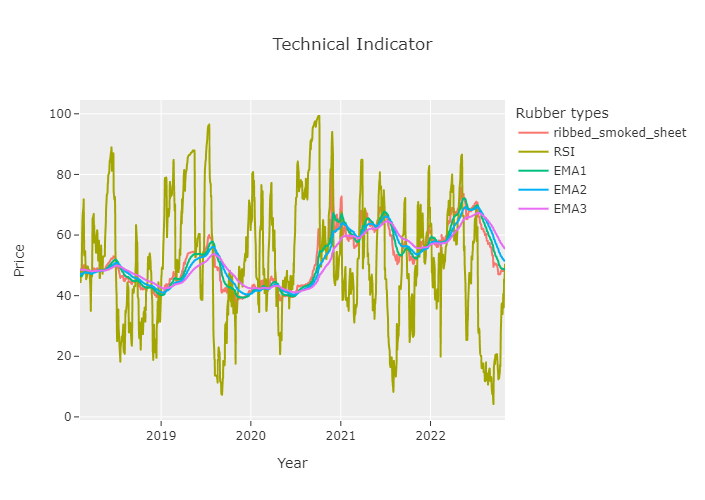

In [218]:
# plot indicator
px.line(rubber_lag[['ribbed_smoked_sheet', 'RSI', 'EMA1', 'EMA2', 'EMA3']].dropna(),
        title='Technical Indicator',
        template='ggplot2', labels={'value':'Price', 'date':'Year', 'variable':'Rubber types'},
                 width=1000, height=500)

In [219]:
# concatenate target and lagged features
rubber_train = pd.concat([rubber[['ribbed_smoked_sheet']], rubber_lag.drop('ribbed_smoked_sheet', axis=1)], axis=1)
rubber_train.dropna(inplace=True)

In [220]:
# create time series object for target variable
ts_P = TimeSeries.from_series(rubber_train["ribbed_smoked_sheet"], freq='B') 

# check attributes of the time series
print("components:", ts_P.components)
print("duration:",ts_P.duration)
print("frequency:",ts_P.freq)
print("frequency:",ts_P.freq_str)
print("has date time index? (or else, it must have an integer index):",ts_P.has_datetime_index)
print("deterministic:",ts_P.is_deterministic)
print("univariate:",ts_P.is_univariate)

components: Index(['ribbed_smoked_sheet'], dtype='object', name='component')
duration: 1729 days 00:00:00
frequency: <BusinessDay>
frequency: B
has date time index? (or else, it must have an integer index): True
deterministic: True
univariate: True


In [221]:
# train/test split and scaling of target variable
ts_train, ts_test = ts_P.split_after(split_point=SPLIT)
print("training start:", ts_train.start_time())
print("training end:", ts_train.end_time())
print("training duration:",ts_train.duration)
print("test start:", ts_test.start_time())
print("test end:", ts_test.end_time())
print("test duration:", ts_test.duration)

training start: 2018-02-05 00:00:00
training end: 2022-10-03 00:00:00
training duration: 1701 days 00:00:00
test start: 2022-10-04 00:00:00
test end: 2022-10-31 00:00:00
test duration: 27 days 00:00:00


In [222]:
# standardize features
scalerP = Scaler()
scalerP.fit_transform(ts_train)
ts_ttrain = scalerP.transform(ts_train)
ts_ttest = scalerP.transform(ts_test)    
ts_t = scalerP.transform(ts_P)

print("first and last row of scaled price time series:")
pd.options.display.float_format = '{:,.2f}'.format
ts_t.pd_dataframe().iloc[[0,-1]]

first and last row of scaled price time series:


component,ribbed_smoked_sheet
date,
2018-02-05,0.25
2022-10-31,0.29


In [223]:
# make sure data are of type float
ts_t = ts_t.astype(np.float32)
ts_ttrain = ts_ttrain.astype(np.float32)
ts_ttest = ts_ttest.astype(np.float32)

### Covariates

In [224]:
# create time series object for the feature columns
df_covF = rubber_train.loc[:, rubber_train.columns != "ribbed_smoked_sheet"]
ts_covF = TimeSeries.from_dataframe(df_covF)

# check attributes of the time series
print("components (columns) of feature time series:", ts_covF.components)
print("duration:",ts_covF.duration)
print("frequency:",ts_covF.freq)
print("frequency:",ts_covF.freq_str)
print("has date time index? (or else, it must have an integer index):",ts_covF.has_datetime_index)
print("deterministic:",ts_covF.is_deterministic)
print("univariate:",ts_covF.is_univariate)

components (columns) of feature time series: Index(['cup_lump', 'rubber_sheet', 'latex', 'fob', 'tocom', 'sicom', 'jpy',
       'sgd', 'crude_oil', 'RSI', 'EMA1', 'EMA2', 'EMA3'],
      dtype='object', name='component')
duration: 1729 days 00:00:00
frequency: <BusinessDay>
frequency: B
has date time index? (or else, it must have an integer index): True
deterministic: True
univariate: False


In [225]:
# train/test split and scaling of feature covariates
covF_train, covF_test = ts_covF.split_after(SPLIT)

scalerF = Scaler()
scalerF.fit_transform(covF_train)
covF_ttrain = scalerF.transform(covF_train) 
covF_ttest = scalerF.transform(covF_test)   
covF_t = scalerF.transform(ts_covF)  

# make sure data are of type float
covF_ttrain = covF_ttrain.astype(np.float32)
covF_ttest = covF_ttest.astype(np.float32)

pd.options.display.float_format = '{:.2f}'.format
print("first and last row of scaled feature covariates:")
covF_t.pd_dataframe().iloc[[0,-1]]

first and last row of scaled feature covariates:


component,cup_lump,rubber_sheet,latex,fob,tocom,sicom,jpy,sgd,crude_oil,RSI,EMA1,EMA2,EMA3
date,,,,,,,,,,,,,
2018-02-05,0.34,0.20,0.21,0.23,0.35,0.25,0.43,0.50,0.21,0.47,0.22,0.24,0.29
2022-10-31,0.57,0.26,0.31,0.39,0.46,0.13,0.90,0.95,0.54,0.48,0.29,0.39,0.55


In [226]:
# feature engineering - create time covariates: hour, weekday, month, quarter, year
# 41 days (2 months) beyond end of test set to prepare for out-of-sample forecasting
covT = datetime_attribute_timeseries(ts_P.time_index, attribute="day", one_hot=True, add_length=22) 
covT = covT.stack(  datetime_attribute_timeseries(covT.time_index, one_hot=True, attribute="month")  )
covT = covT.stack(  datetime_attribute_timeseries(covT.time_index, one_hot=True, attribute="quarter")  )
covT = covT.astype(np.float32)


covT_t = covT.copy()
covT_t = covT_t.astype(np.float32)


pd.options.display.float_format = '{:.0f}'.format
print("first and last row of unscaled time covariates:")
covT.pd_dataframe().iloc[[0,-1]]

first and last row of unscaled time covariates:


component,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,...,month_7,month_8,month_9,month_10,month_11,month_12,quarter_1,quarter_2,quarter_3,quarter_4
time,,,,,,,,,,,,,,,,,,,,,
2018-02-05,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2022-11-30,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1


In [227]:
# combine feature and time covariates along component dimension: axis=1
ts_cov = ts_covF.concatenate( covT.slice_intersect(ts_covF), axis=1 )                      # unscaled F+T
cov_t = covF_t.concatenate( covT_t.slice_intersect(covF_t), axis=1 )                       # scaled F+T
cov_t = cov_t.astype(np.float32)

pd.options.display.float_format = '{:.2f}'.format
print("first and last row of unscaled covariates:")
ts_cov.pd_dataframe().iloc[[0,-1]]

first and last row of unscaled covariates:


component,cup_lump,rubber_sheet,latex,fob,tocom,sicom,jpy,sgd,crude_oil,RSI,...,month_7,month_8,month_9,month_10,month_11,month_12,quarter_1,quarter_2,quarter_3,quarter_4
date,,,,,,,,,,,,,,,,,,,,,
2018-02-05,36.00,44.45,41.50,52.80,202.80,167.30,3.52,24.25,51.83,48.55,...,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
2022-10-31,42.00,46.51,45.70,59.60,226.00,148.30,3.82,26.31,78.72,50.27,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00


In [228]:
# config model
model = NBEATSModel(    
    input_chunk_length=INLEN,
                        output_chunk_length=N_FC, 
                        num_stacks=BLOCKS,
                        layer_widths=LWIDTH,
                        batch_size=BATCH,
                        n_epochs=EPOCHS,
                        nr_epochs_val_period=VALWAIT, 
                        likelihood=QuantileRegression(QUANTILES), 
                        optimizer_kwargs={"lr": LEARN}, 
                        model_name="NBEATS_RSS_indicator",
                        log_tensorboard=True,
                        generic_architecture=True, 
                        random_state=RAND,
                        force_reset=True,
                        save_checkpoints=True
                    )

In [229]:
# training: load a saved model or (re)train
if LOAD:
    print("have loaded a previously saved model from disk:" + mpath)
    model = NBEATSModel.load_model(mpath)                            # load previously model from disk 
else:
    model.fit(  series=ts_ttrain, 
                past_covariates=covT_t,
                val_series=ts_ttest, 
                val_past_covariates=covT_t, 
                verbose=True)
    print("have saved the model after training:", mpath)
    model.save_model(mpath)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

have saved the model after training: D:\tda\dsi\capstone\code.\..\model\_NBEATS_rss_model_indicator.pth.tar


In [230]:
model = model.load_from_checkpoint('NBEATS_RSS')

In [231]:
# testing: generate predictions
ts_tpred = model.predict(   n=len(ts_ttest),  
                            past_covariates=covT_t,
                            num_samples=N_SAMPLES,   
                            n_jobs=N_JOBS, 
                            verbose=True)
                            
                            
                            
# retrieve forecast series for chosen quantiles, 
# inverse-transform each series,
# insert them as columns in a new dataframe dfY
q50_RMSE = np.inf
q50_MAPE = np.inf
ts_q50 = None
pd.options.display.float_format = '{:,.2f}'.format
dfY = pd.DataFrame()
dfY["Actual"] = TimeSeries.pd_series(ts_test['ribbed_smoked_sheet'])


# helper function: get forecast values for selected quantile q and insert them in dataframe dfY
def predQ(ts_t, q):
    ts_tq = ts_t.quantile_timeseries(q)
    ts_q = scalerP.inverse_transform(ts_tq)
    s = TimeSeries.pd_series(ts_q)
    header = "Q" + format(int(q*100), "02d")
    dfY[header] = s
  
# call helper function predQ, once for every quantile
_ = [predQ(ts_tpred['ribbed_smoked_sheet'], q) for q in QUANTILES]

# move Q50 column to the left of the Actual column
col = dfY.pop("Q50")
dfY.insert(1, col.name, col)
dfY.iloc[np.r_[0:2, -2:0]]

Predicting: 0it [00:00, ?it/s]

,Actual,Q50,Q01,Q10,Q20,Q80,Q90,Q99
date,,,,,,,,
2022-10-04,49.90,46.87,41.71,42.30,44.60,47.52,47.85,48.93
2022-10-05,50.41,46.63,39.67,41.69,44.12,47.84,48.35,50.22
2022-10-28,49.76,43.95,37.16,40.73,41.77,47.12,48.49,50.76
2022-10-31,49.47,43.06,36.08,39.62,40.84,45.41,46.81,48.25


In [232]:
# check MAPE scores from all quantile range
for col in dfY.columns:
    print(f"mape {col} {mape(TimeSeries.from_series(dfY['Actual'], freq='B'), TimeSeries.from_series(dfY[col], freq='B'))}")

mape Actual 0.0
mape Q50 9.71960303897549
mape Q01 23.10126155886985
mape Q10 17.84123621396952
mape Q20 14.72311457017273
mape Q80 5.801963212212387
mape Q90 4.120828528054542
mape Q99 2.368157249846475


In [233]:
def compare_value(y_test, preds, title=None):
    df = pd.concat([y_test, preds], axis=1)
    df.columns = ['true', 'preds']
    
    fig = go.Figure(layout = go.Layout(template='ggplot2'))

    fig.add_scatter(x=df.index, y=df['true'], line={'dash':'dash', 'color':'dodgerblue'}, name='True')
    fig.add_scatter(x=df.index, y=df['preds'], line={'color':'red'}, name='Predict')

    fig.update_layout(title=go.layout.Title(
            text=f"{title}<br><sup>MAPE is {round(mean_absolute_percentage_error(df['true'], df['preds'])*100, 2)}%</sup>\
            <br><sup>RMSE is {round(mean_squared_error(y_test, preds, square_root=True), 2)}<sup>",
            xref="paper",
            x=0))

    fig.show()

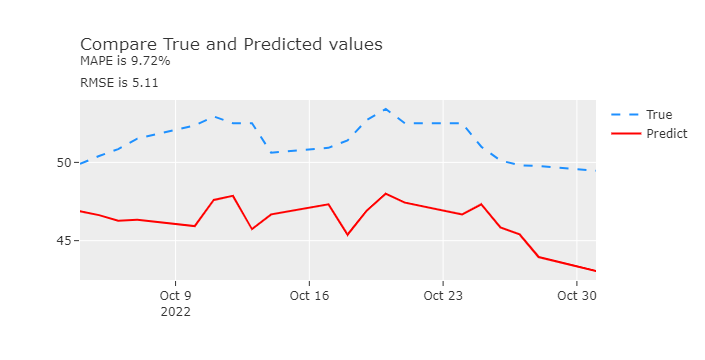

In [236]:
# compare true and predicted values
compare_value(dfY['Actual'], dfY['Q50'], 'Compare True and Predicted values')

---

## Part 6: Conclusion and Recommendation

### Conclusion

“Build model to forecast Ribbed smoked sheet prices next 1 month to estimate trend of RSS prices for Rubber cooperative. Model performance will evaluate by MAPE. Will working in production part if score better than baseline 5%” From this statement, This project is fail because the data has complex trend and confounding seasonality and final model is capture wrong trend But it keep better by do more features engineer. This project can still working toward to find confounding variables.

### Recommendation

After research what might also affect rss price. It is the rubber stock of Rubber authorities of Thailand(RAOT) because RAOT has rubber stock in warehouse too many quantity and if it sold to foreigner it also effect to rss price in Thailand it can decrease demand outside thailand. Thus, what need to be include is RAOT rubber stock quantity it might help model perform better [source](https://www.thairath.co.th/news/local/south/650456)